<a href="https://colab.research.google.com/github/Pradhyumn1/my_algo_trading/blob/main/Unsupervised_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=5c91e5ec50b772e1a0c85019d42e38350e37e717b975273488fc53baee7d978f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
!pip install git+https://github.com/robertmartin8/PyPortfolioOpt.git


  Cloning https://github.com/robertmartin8/PyPortfolioOpt.git to /tmp/pip-req-build-hh_phyc_
  Running command git clone --filter=blob:none --quiet https://github.com/robertmartin8/PyPortfolioOpt.git /tmp/pip-req-build-hh_phyc_
  Resolved https://github.com/robertmartin8/PyPortfolioOpt.git to commit 46f84850febb73a0fa1811114adffe27bde91f08
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

In [ ]:
warnings.filterwarnings('ignore')

# Retrieve S&P 500 company symbols from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

# Set start and end dates for data retrieval
end_date = '2025-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365 * 8)

# Download historical stock data using Yahoo Finance
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2017-09-29 A        61.217041   64.199997   64.279999   63.720001   64.000000   
           AAL      46.185768   47.490002   47.849998   47.230000   47.490002   
           AAPL     36.304012   38.529999   38.532501   38.000000   38.302502   
           ABBV     67.243988   88.860001   89.349998   87.669998   88.690002   
           ABT      47.949158   53.360001   53.790001   53.290001   53.639999   
...                       ...         ...         ...         ...         ...   
2023-12-22 YUM     130.000000  130.000000  130.500000  129.410004  129.899994   
           ZBH     120.559998  120.559998  121.089996  119.910004  120.300003   
           ZBRA    269.410004  269.410004  269.829987  265.890015  266.769989   
           ZION     44.000000   44.000000   44.779999   43.520000   44.279999   
           ZTS     194.979996  194.979996  195.910004  192.740005  195.320007   

                        volume  
date       ticker               
2017-09-29 A         1672800.0  
           AAL       4904300.0  
           AAPL    105199200.0  
           ABBV      6769400.0  
           ABT       8459000.0  
...                        ...  
2023-12-22 YUM        991500.0  
           ZBH       1337800.0  
           ZBRA       225900.0  
           ZION      1534500.0  
           ZTS       1548400.0  

[779431 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.

*   Garman-Klass Volatility
*   RSI
*   Bollinger Bands
*   ATR
*   MACD
*   Dollar Volume









In [ ]:
# Compute additional features
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2 * np.log(2) - 1) * (
            (np.log(df['adj close']) - np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

In [ ]:
# Function to compute ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Function to compute MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df



adj close       close        high         low        open  \
date       ticker                                                               
2017-09-29 A        61.217041   64.199997   64.279999   63.720001   64.000000   
           AAL      46.185768   47.490002   47.849998   47.230000   47.490002   
           AAPL     36.304012   38.529999   38.532501   38.000000   38.302502   
           ABBV     67.243988   88.860001   89.349998   87.669998   88.690002   
           ABT      47.949158   53.360001   53.790001   53.290001   53.639999   
...                       ...         ...         ...         ...         ...   
2023-12-22 YUM     130.000000  130.000000  130.500000  129.410004  129.899994   
           ZBH     120.559998  120.559998  121.089996  119.910004  120.300003   
           ZBRA    269.410004  269.410004  269.829987  265.890015  266.769989   
           ZION     44.000000   44.000000   44.779999   43.520000   44.279999   
           ZTS     194.979996  194.979996  195.910004  192.740005  195.320007   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-09-29 A         1672800.0         -0.000725        NaN       NaN   
           AAL       4904300.0         -0.000215        NaN       NaN   
           AAPL    105199200.0         -0.001012        NaN       NaN   
           ABBV      6769400.0         -0.029421        NaN       NaN   
           ABT       8459000.0         -0.004815        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-22 YUM        991500.0          0.000035  58.269030  4.820020   
           ZBH       1337800.0          0.000046  66.726525  4.739342   
           ZBRA       225900.0          0.000071  67.768919  5.395231   
           ZION      1534500.0          0.000392  65.118189  3.533169   
           ZTS       1548400.0          0.000132  64.683243  5.150301   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-09-29 A            NaN       NaN       NaN       NaN     102.403866  
           AAL          NaN       NaN       NaN       NaN     226.508863  
           AAPL         NaN       NaN       NaN       NaN    3819.153051  
           ABBV         NaN       NaN       NaN       NaN     455.201453  
           ABT          NaN       NaN       NaN       NaN     405.601925  
...                     ...       ...       ...       ...            ...  
2023-12-22 YUM     4.856170  4.892321 -0.035785  0.712966     128.895000  
           ZBH     4.773957  4.808573 -1.141743  0.923768     161.285165  
           ZBRA    5.514776  5.634320 -0.338566  1.342675      60.859720  
           ZION    3.702744  3.872320  0.297162  2.081594      67.518000  
           ZTS     5.238482  5.326663  0.423478  2.165652     301.907025  

[779431 rows x 14 columns]

# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [ ]:
# Assuming df is your DataFrame
# If the index is a tuple of (date, ticker), extract the date component
df['date'] = [date for date, _ in df.index]
df['date'] = pd.to_datetime(df['date'])
df.set_index(['date', df.index.get_level_values('ticker')], inplace=True)

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = (pd.concat([
    df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')],
    axis=1)).dropna()
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2017-11-30 A          131.316259   66.158867 -1.247912  4.225022  4.168509   
           AAL        162.390159   49.210899  0.533063  3.911097  3.802852   
           AAPL      4648.552525   40.625946 -1.331137  3.758357  3.706239   
           ABBV       346.019728   73.854996 -0.802600  4.318609  4.262454   
           ABT        263.014032   50.901699 -1.580223  3.951504  3.915216   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        228.753441  130.000000 -0.035785  4.892321  4.820020   
           ZBH        226.347168  120.559998 -1.141743  4.808573  4.739342   
           ZBRA       106.376375  269.410004 -0.338566  5.634320  5.395231   
           ZION       114.451640   44.000000  0.297162  3.872320  3.533169   
           ZTS        376.288920  194.979996  0.423478  5.326663  5.150301   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2017-11-30 A       4.196765         -0.000468  0.186918  57.669382  
           AAL     3.856975          0.000602  0.213081  61.725913  
           AAPL    3.732298         -0.000640 -0.002508  58.917403  
           ABBV    4.290531         -0.027237  0.212166  63.420024  
           ABT     3.933360         -0.002886  0.036774  59.557176  
...                     ...               ...       ...        ...  
2023-12-31 YUM     4.856170          0.000035  0.712966  58.269030  
           ZBH     4.773957          0.000046  0.923768  66.726525  
           ZBRA    5.514776          0.000071  1.342675  67.768919  
           ZION    3.702744          0.000392  2.081594  65.118189  
           ZTS     5.238482          0.000132  2.165652  64.683243  

[36760 rows x 9 columns]

In [ ]:
# Calculate 5-year rolling average of dollar volume for each stock before filtering
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5 * 12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank'] < 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-10-31 AAL      34.426762  1.943910  3.619895  3.400271  3.510083   
           AAPL     52.333458 -0.666068  4.017800  3.941065  3.979433   
           ABBV     61.636578  0.223749  4.370821  4.127367  4.249094   
           ABT      63.393223 -0.457488  4.207358  4.123324  4.165341   
           ACN     146.955154 -0.565455  5.071378  4.941942  5.006660   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    405.250000  1.502288  6.058231  5.787487  5.922859   
           VZ       37.490002 -1.117874  3.683355  3.633355  3.658355   
           WFC      49.180000 -0.541599  3.968061  3.759409  3.863735   
           WMT     156.649994  0.035412  5.067815  5.019873  5.043844   
           XOM     101.910004  0.143378  4.661205  4.592856  4.627031   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2018-10-31 AAL             0.000304 -1.280086  48.657563  
           AAPL           -0.000331 -0.457490  50.232941  
           ABBV           -0.027617 -1.741409  30.333999  
           ABT            -0.002295 -0.456423  51.539002  
           ACN            -0.001209 -0.924389  44.756065  
...                             ...       ...        ...  
2023-12-31 VRTX            0.000057  2.932403  66.312454  
           VZ              0.000050  0.695165  56.728216  
           WFC             0.000085  2.114768  69.479421  
           WMT             0.000058 -0.843714  50.562973  
           XOM             0.000054 -0.665439  47.162070  

[9387 rows x 8 columns]

# 4. Calculate Monthly Returns for different time horizons as features.

In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2019-10-31 AAL      29.852554 -0.120091  3.481206  3.263377  3.372292   
           AAPL     60.406124 -1.010584  4.131779  4.010067  4.070923   
           ABBV     66.541763 -1.408240  4.224623  4.104134  4.164379   
           ABT      78.158043 -0.495730  4.381628  4.308230  4.344929   
           ACN     175.054947 -0.737470  5.188030  5.148687  5.168359   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    405.250000  1.502288  6.058231  5.787487  5.922859   
           VZ       37.490002 -1.117874  3.683355  3.633355  3.658355   
           WFC      49.180000 -0.541599  3.968061  3.759409  3.863735   
           WMT     156.649994  0.035412  5.067815  5.019873  5.043844   
           XOM     101.910004  0.143378  4.661205  4.592856  4.627031   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2019-10-31 AAL             0.000296  1.293046  58.952265   0.114572   
           AAPL            0.000996  0.412940  68.908122   0.110684   
           ABBV           -0.012515  0.786729  70.480918   0.065900   
           ABT            -0.001711  0.023899  54.403483   0.003289   
           ACN            -0.001262 -0.494079  47.064258  -0.031886   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000057  2.932403  66.312454   0.142161   
           VZ              0.000050  0.695165  56.728216  -0.021915   
           WFC             0.000085  2.114768  69.479421   0.102938   
           WMT             0.000058 -0.843714  50.562973   0.009903   
           XOM             0.000054 -0.665439  47.162070  -0.008079   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-10-31 AAL      0.068893  -0.003775  -0.020137  -0.018144   -0.011810  
           AAPL     0.091660   0.054360   0.037773   0.047048    0.012026  
           ABBV     0.108023   0.066042   0.005284   0.003732    0.006402  
           ABT     -0.008089  -0.012222   0.009611   0.016558    0.017601  
           ACN     -0.030628  -0.011138   0.003210   0.022600    0.014688  
...                      ...        ...        ...        ...         ...  
2023-12-31 VRTX     0.057892   0.052340   0.023800   0.028362    0.028639  
           VZ       0.033044   0.052593   0.007847   0.002070    0.001767  
           WFC      0.116976   0.066878   0.026755   0.033758    0.017288  
           WMT     -0.019086  -0.005656   0.000647   0.007984    0.009613  
           XOM     -0.014312  -0.043660  -0.005618  -0.005251   -0.003788  

[7328 rows x 14 columns]

# **5. Download Fama-French Factors and Calculate Rolling Factor Betas.**

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2019')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-10-31 AAL     0.0206  0.0026 -0.0191  0.0044 -0.0096   0.114572
           AAPL    0.0206  0.0026 -0.0191  0.0044 -0.0096   0.110684
           ABBV    0.0206  0.0026 -0.0191  0.0044 -0.0096   0.065900
           ABT     0.0206  0.0026 -0.0191  0.0044 -0.0096   0.003289
           ACN     0.0206  0.0026 -0.0191  0.0044 -0.0096  -0.031886
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[7040 rows x 6 columns]

**Filter out stocks with less than 10 months of data.**

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-10-31 AAL     0.0206  0.0026 -0.0191  0.0044 -0.0096   0.114572
           AAPL    0.0206  0.0026 -0.0191  0.0044 -0.0096   0.110684
           ABBV    0.0206  0.0026 -0.0191  0.0044 -0.0096   0.065900
           ABT     0.0206  0.0026 -0.0191  0.0044 -0.0096   0.003289
           ACN     0.0206  0.0026 -0.0191  0.0044 -0.0096  -0.031886
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[7005 rows x 6 columns]

*Calculate Rolling Factor Betas.*

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas


Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-10-31 VRTX    0.516767 -0.607688 -0.243168 -0.126238  0.714360
           VZ      0.351044 -0.546477  0.453754  0.268490 -0.152312
           WFC     1.081142  0.342198  2.046439 -0.410924 -1.505578
           WMT     0.692230 -0.349303 -0.352250 -0.140002  0.463836
           XOM     1.020157 -0.778704  1.608110 -0.637487 -0.137529

[7005 rows x 5 columns]

*Join the rolling factors data to the main features dataframe.*

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7120 entries, (Timestamp('2019-10-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-12-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               7120 non-null   float64
 1   bb_high           7120 non-null   float64
 2   bb_low            7120 non-null   float64
 3   bb_mid            7120 non-null   float64
 4   garman_klass_vol  7120 non-null   float64
 5   macd              7120 non-null   float64
 6   rsi               7120 non-null   float64
 7   return_1m         7120 non-null   float64
 8   return_2m         7120 non-null   float64
 9   return_3m         7120 non-null   float64
 10  return_6m         7120 non-null   float64
 11  return_9m         7120 non-null   float64
 12  return_12m        7120 non-null   float64
 13  Mkt-RF            7120 non-null   float64
 14  SMB               7120 non-null   float

# 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.


In [ ]:
from sklearn.cluster import KMeans


data = data.dropna()

def get_clusters(df):
    df = df.reset_index(level='date', drop=True)  # If you have a MultiIndex, reset it before clustering
    kmeans = KMeans(n_clusters=4, random_state=0)
    df['cluster'] = kmeans.fit_predict(df)
    return df

data = data.groupby('date').apply(get_clusters)

data


atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2019-10-31 AAL    -0.120091  3.481206  3.263377  3.372292          0.000296   
           AAPL   -1.010584  4.131779  4.010067  4.070923          0.000996   
           ABBV   -1.408240  4.224623  4.104134  4.164379         -0.012515   
           ABT    -0.495730  4.381628  4.308230  4.344929         -0.001711   
           ACN    -0.737470  5.188030  5.148687  5.168359         -0.001262   
...                     ...       ...       ...       ...               ...   
2023-12-31 VRTX    1.502288  6.058231  5.787487  5.922859          0.000057   
           VZ     -1.117874  3.683355  3.633355  3.658355          0.000050   
           WFC    -0.541599  3.968061  3.759409  3.863735          0.000085   
           WMT     0.035412  5.067815  5.019873  5.043844          0.000058   
           XOM     0.143378  4.661205  4.592856  4.627031          0.000054   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2019-10-31 AAL     1.293046  58.952265   0.114572   0.068893  -0.003775   
           AAPL    0.412940  68.908122   0.110684   0.091660   0.054360   
           ABBV    0.786729  70.480918   0.065900   0.108023   0.066042   
           ABT     0.023899  54.403483   0.003289  -0.008089  -0.012222   
           ACN    -0.494079  47.064258  -0.031886  -0.030628  -0.011138   
...                     ...        ...        ...        ...        ...   
2023-12-31 VRTX    2.932403  66.312454   0.142161   0.057892   0.052340   
           VZ      0.695165  56.728216  -0.021915   0.033044   0.052593   
           WFC     2.114768  69.479421   0.102938   0.116976   0.066878   
           WMT    -0.843714  50.562973   0.009903  -0.019086  -0.005656   
           XOM    -0.665439  47.162070  -0.008079  -0.014312  -0.043660   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-10-31 AAL     -0.020137  -0.018144   -0.011810  1.127959  1.815488   
           AAPL     0.037773   0.047048    0.012026  1.226413 -0.271427   
           ABBV     0.005284   0.003732    0.006402  0.671998  0.168038   
           ABT      0.009611   0.016558    0.017601  0.733293  0.000435   
           ACN      0.003210   0.022600    0.014688  1.270927 -0.202017   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.023800   0.028362    0.028639  0.471459 -0.340517   
           VZ       0.007847   0.002070    0.001767  0.418643 -0.287090   
           WFC      0.026755   0.033758    0.017288  1.189632 -0.207530   
           WMT      0.000647   0.007984    0.009613  0.717146 -0.513761   
           XOM     -0.005618  -0.005251   -0.003788  1.084400 -0.174352   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-10-31 AAL     0.584947  0.236962  0.663315        1  
           AAPL   -0.718268  0.364835  0.612585        3  
           ABBV   -0.264937  0.464184  0.590711        3  
           ABT    -0.407707  0.347017  0.804463        2  
           ACN    -0.244233  0.595683  0.035348        2  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.597040  0.270030  1.110386        3  
           VZ      0.310107  0.071184  0.097179        0  
           WFC     1.761143 -0.576728 -1.244791        1  
           WMT    -0.285267 -0.147622  0.547826        0  
           XOM     1.266345 -1.104682  0.244047        2  

[7120 rows x 19 columns]

In [ ]:
# Plotting function
def plot_clusters(data, cluster_column='cluster'):
    clusters = data[cluster_column].unique()

    for cluster in clusters:
        cluster_data = data[data[cluster_column] == cluster]
        plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 6], label=f'Cluster {cluster}')

    plt.legend()
    plt.show()
    return

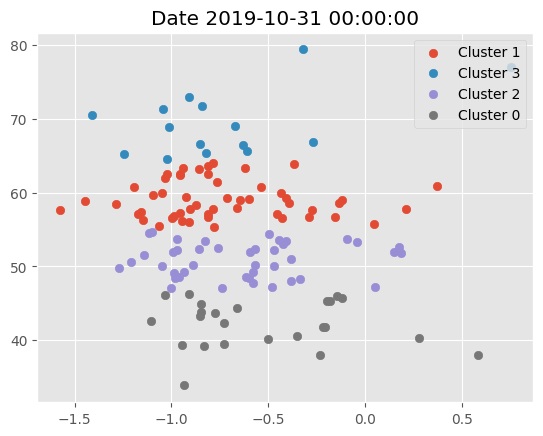

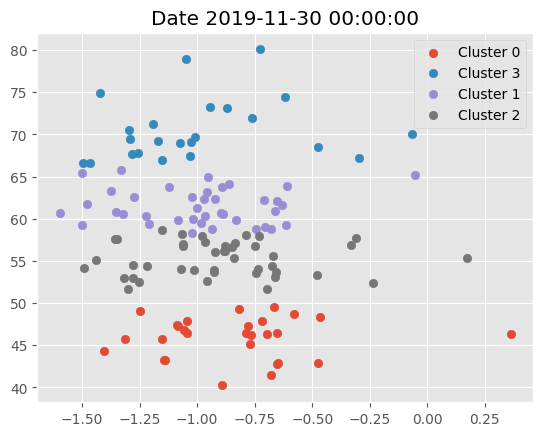

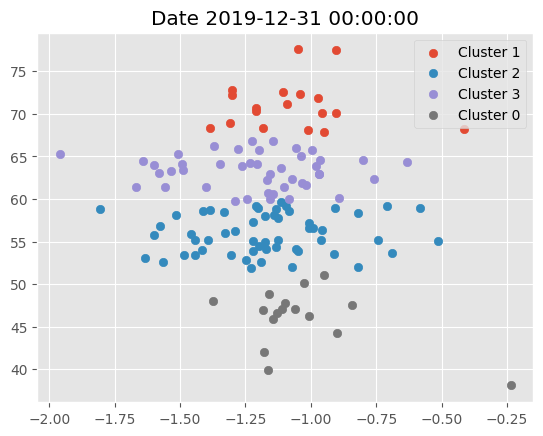

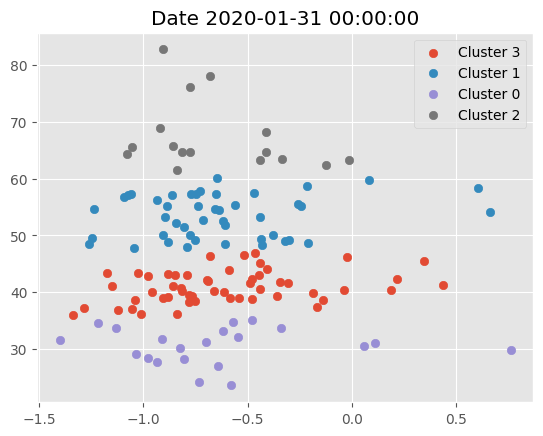

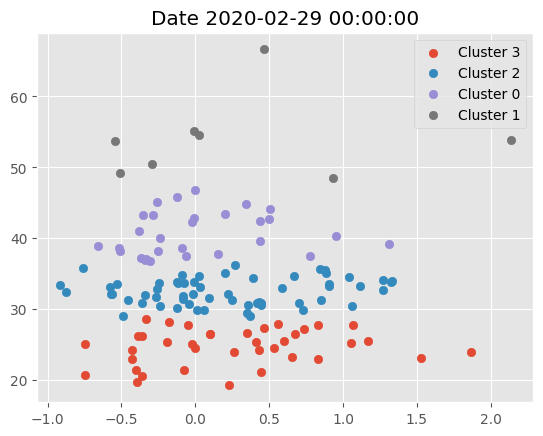

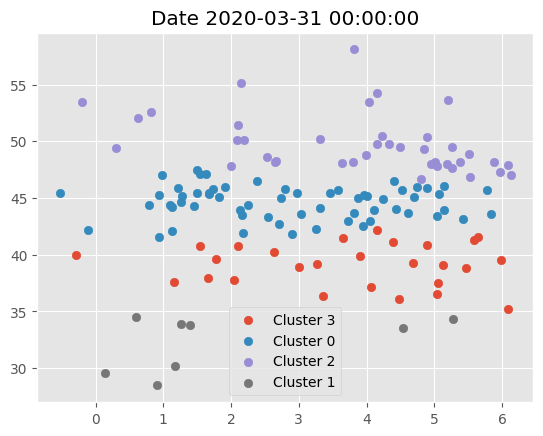

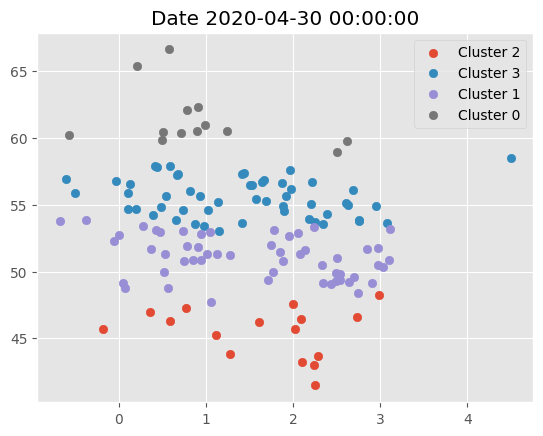

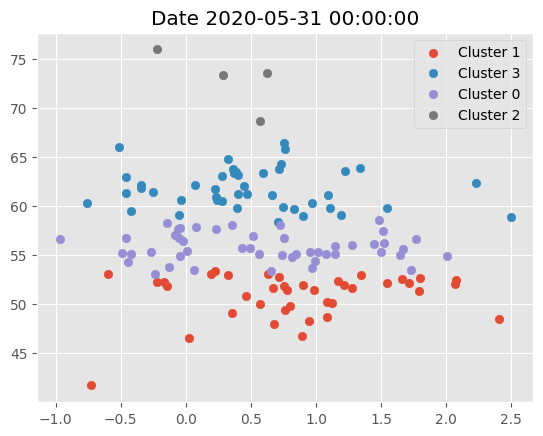

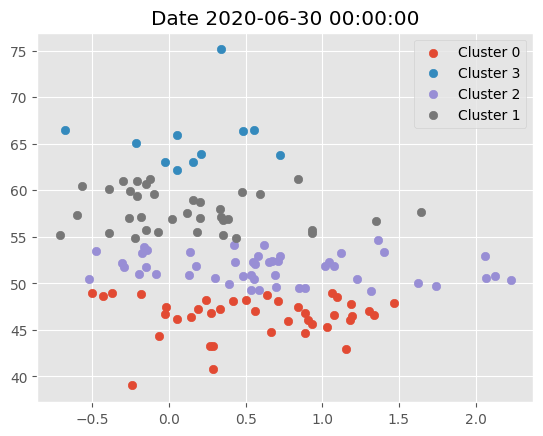

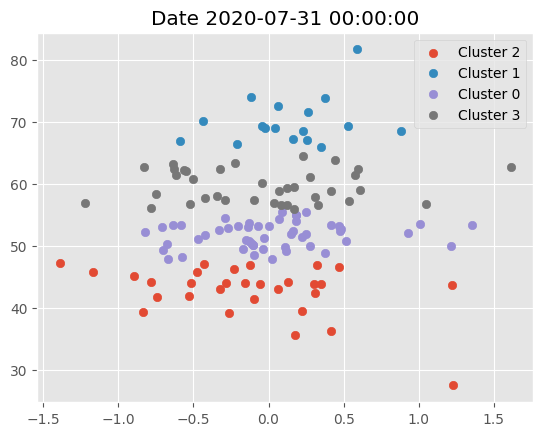

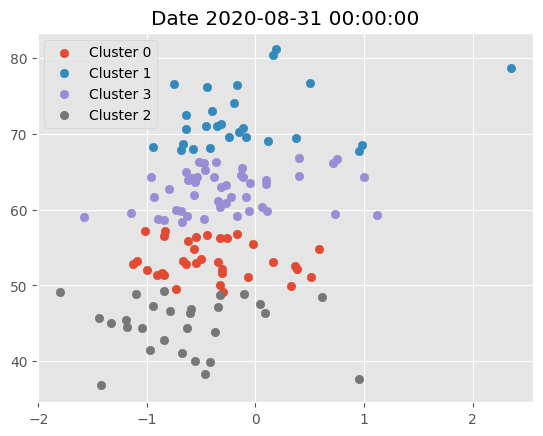

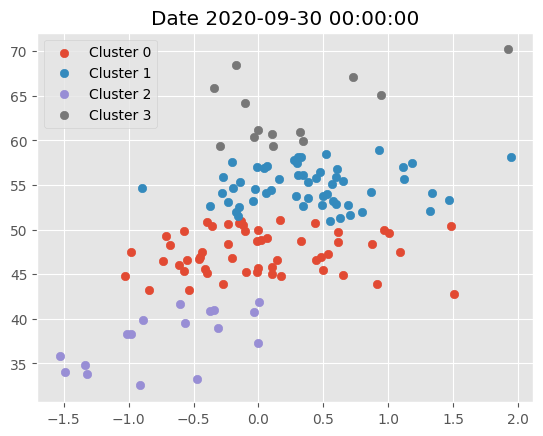

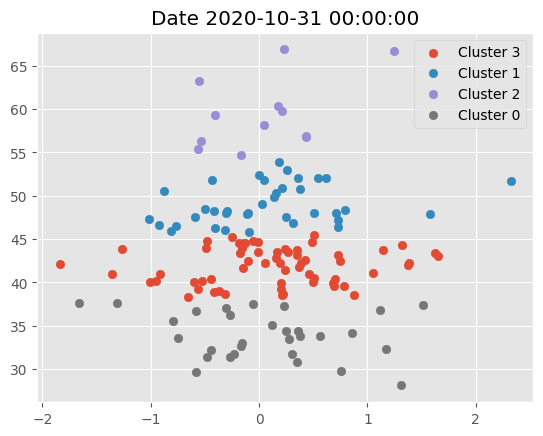

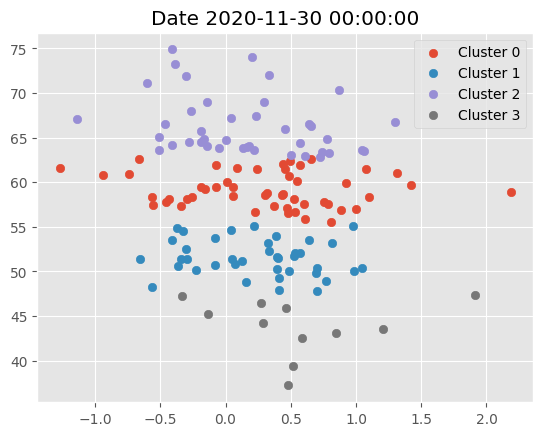

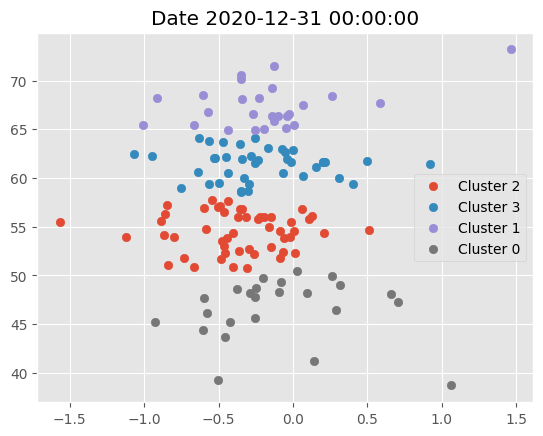

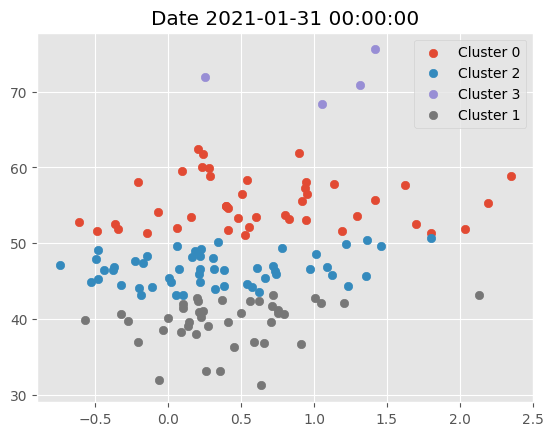

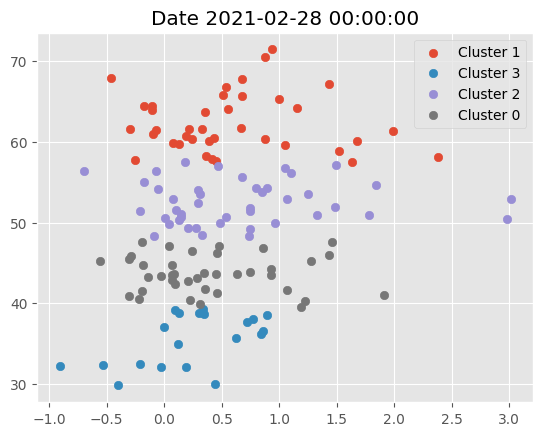

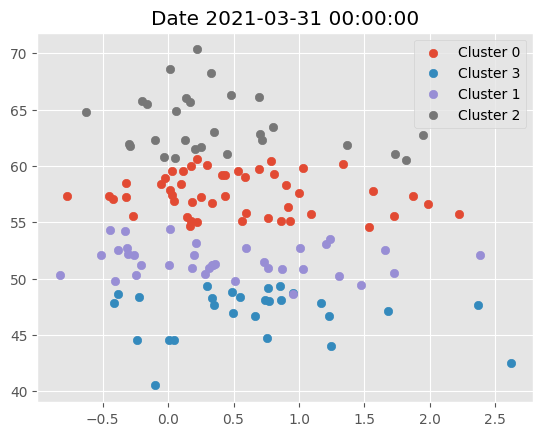

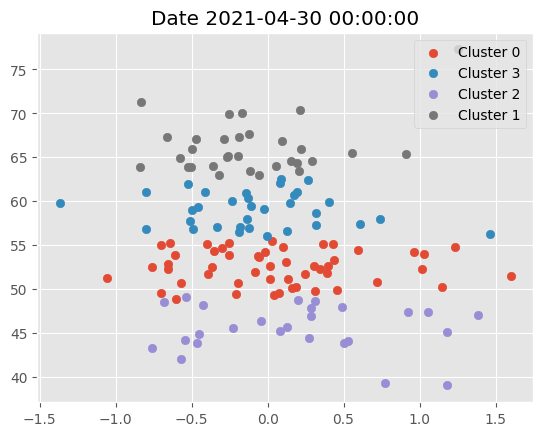

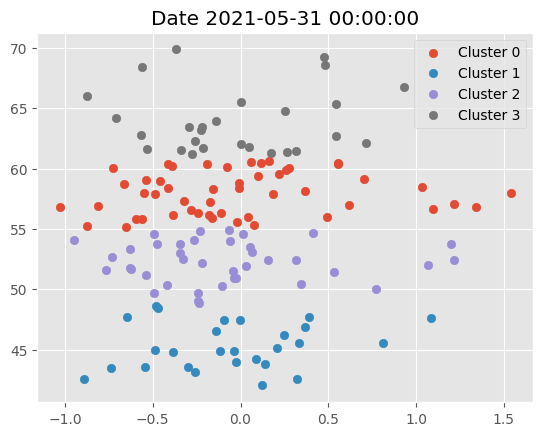

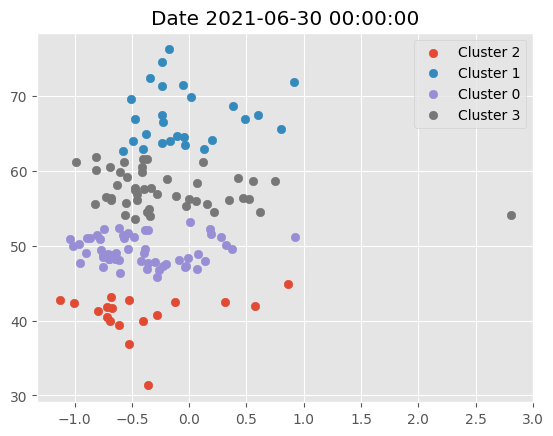

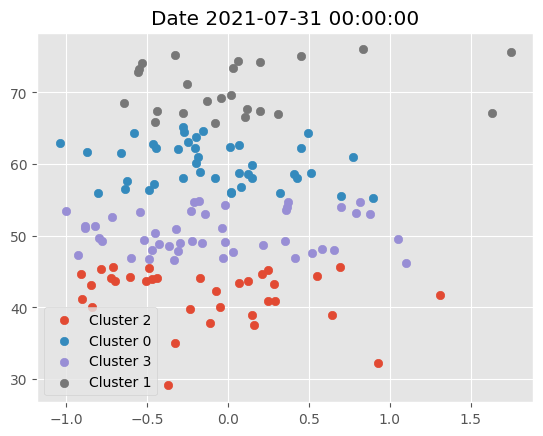

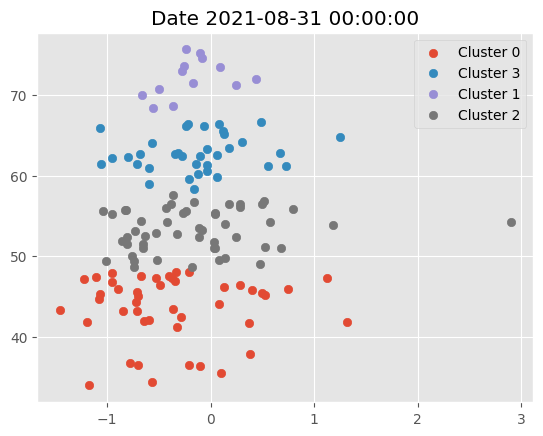

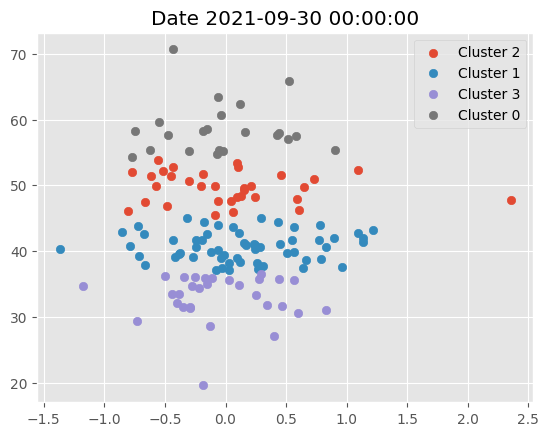

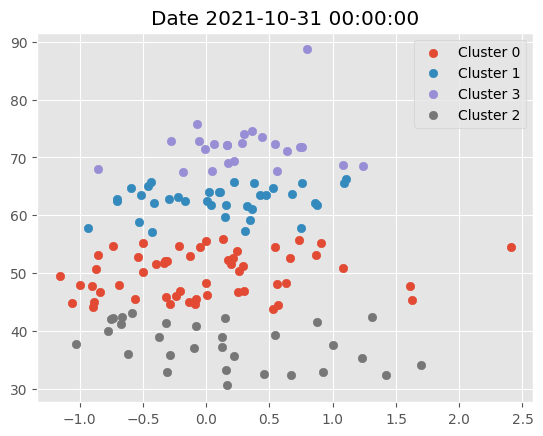

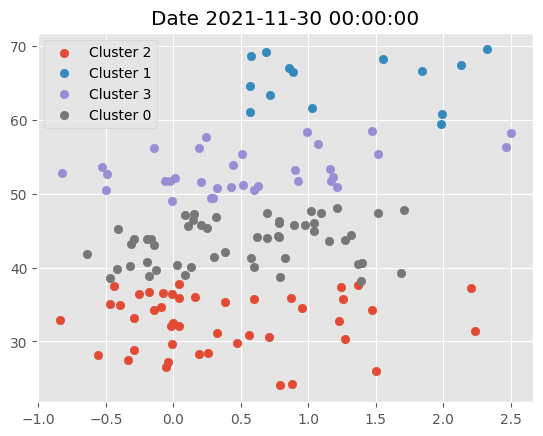

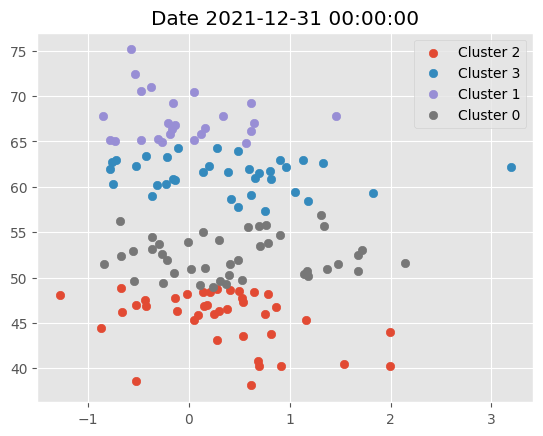

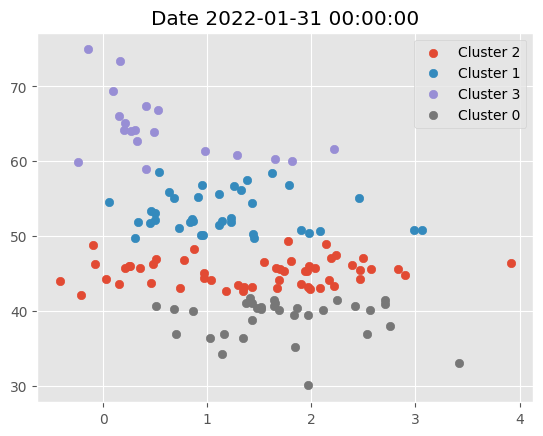

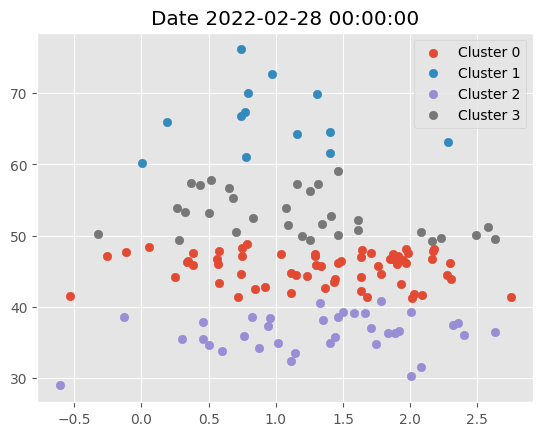

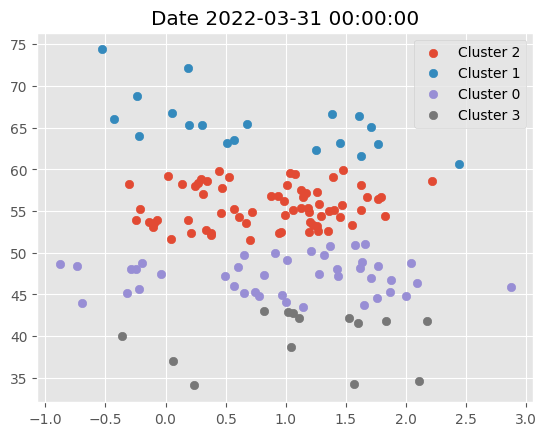

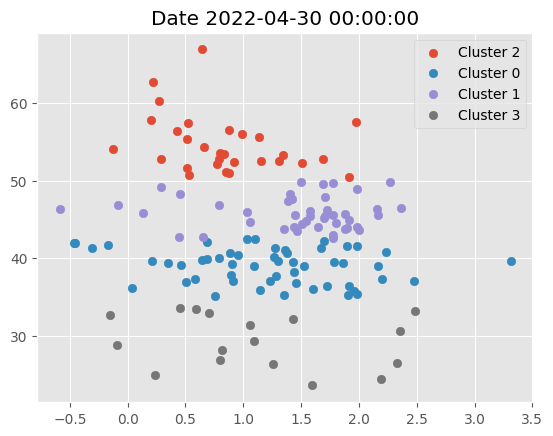

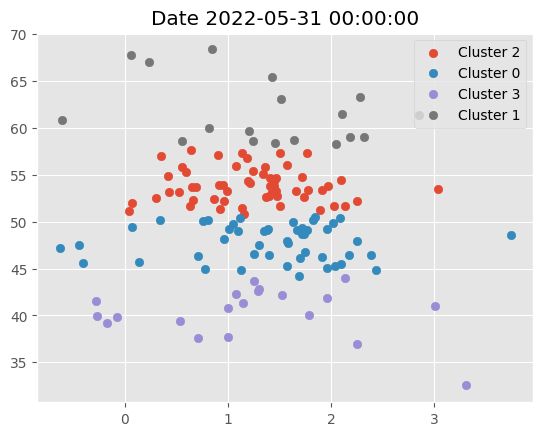

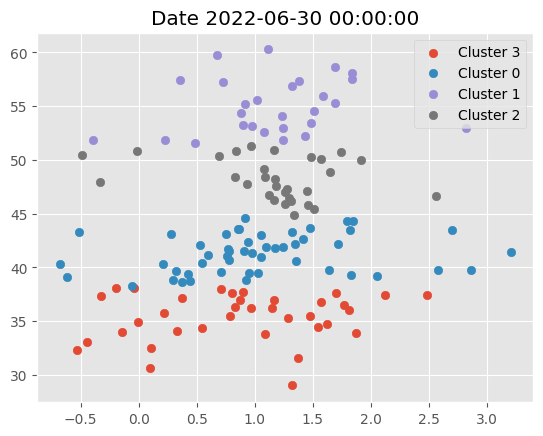

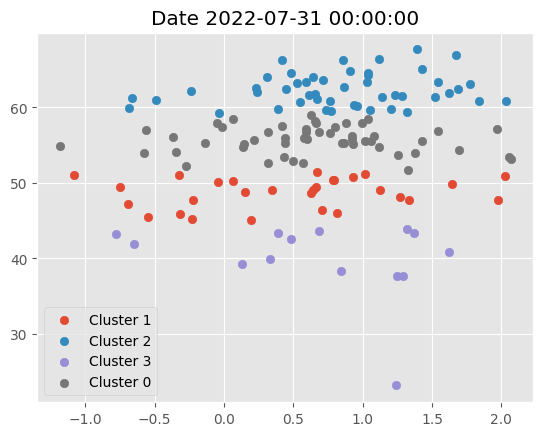

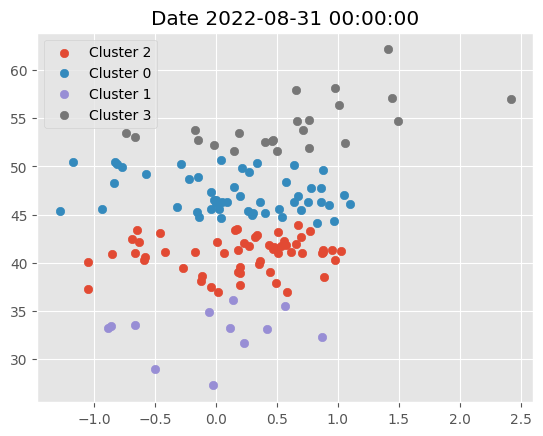

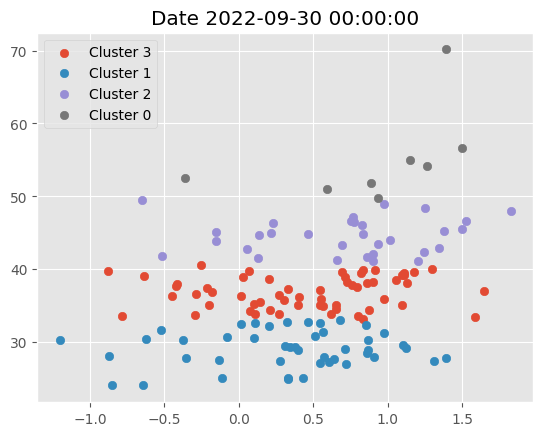

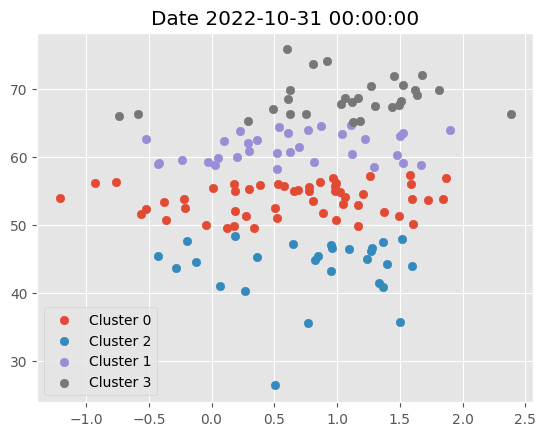

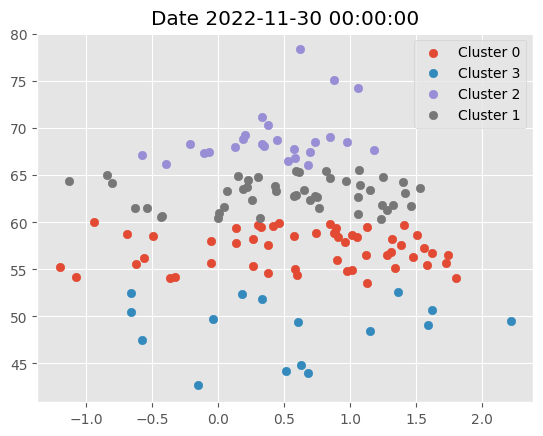

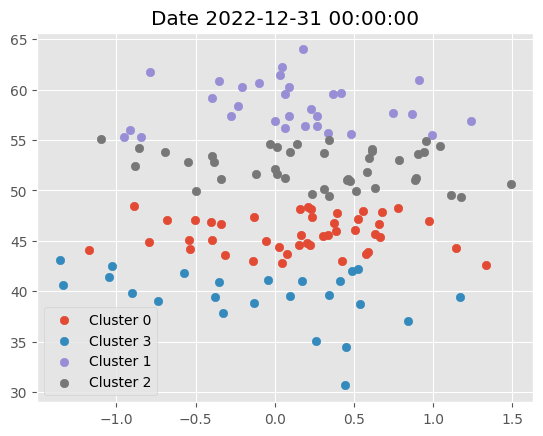

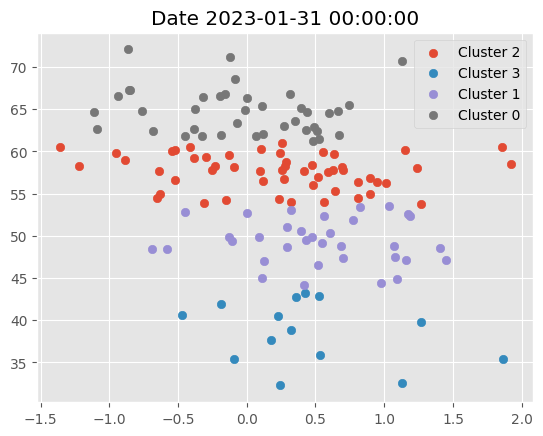

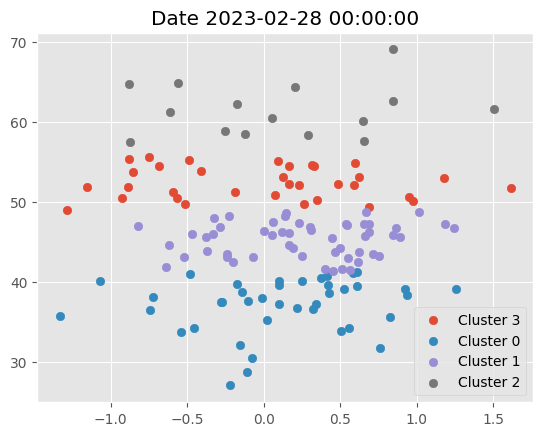

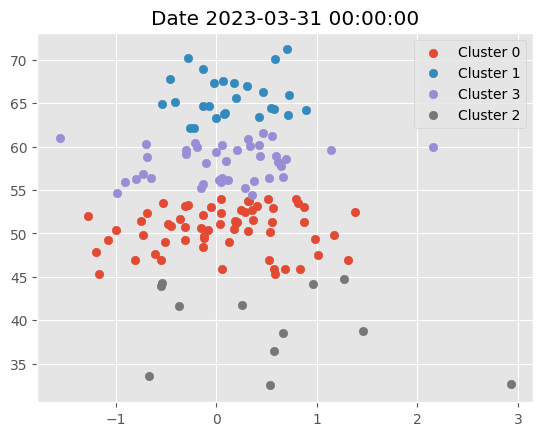

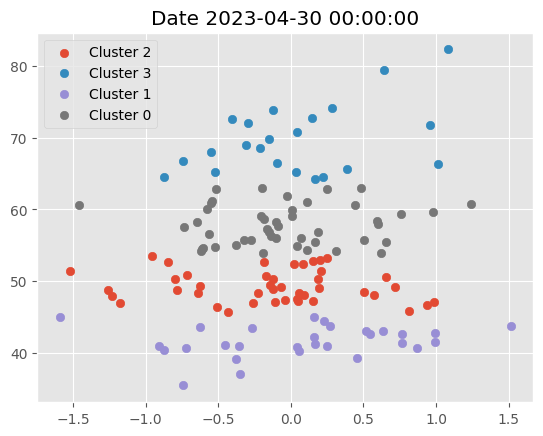

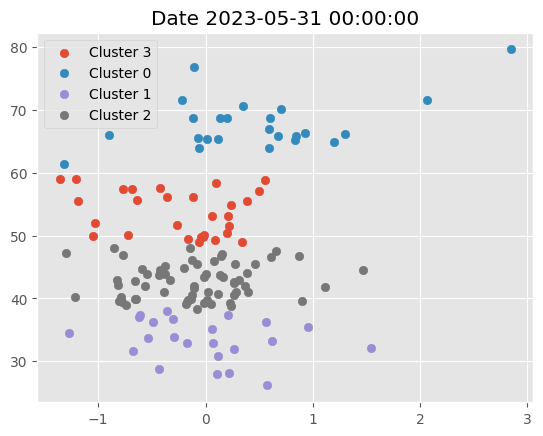

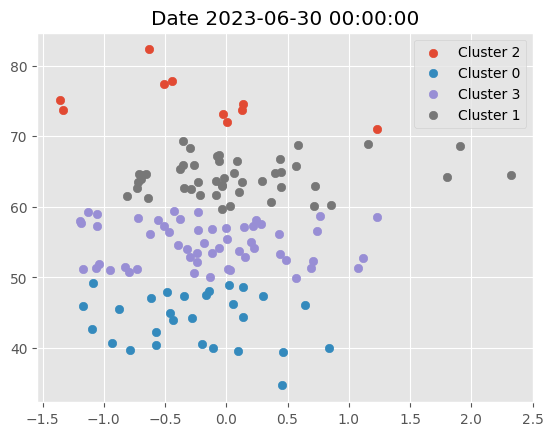

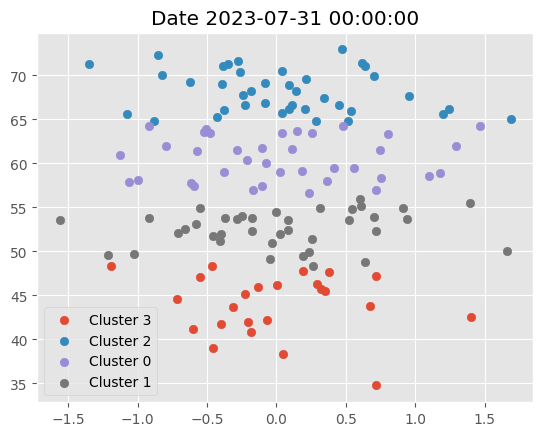

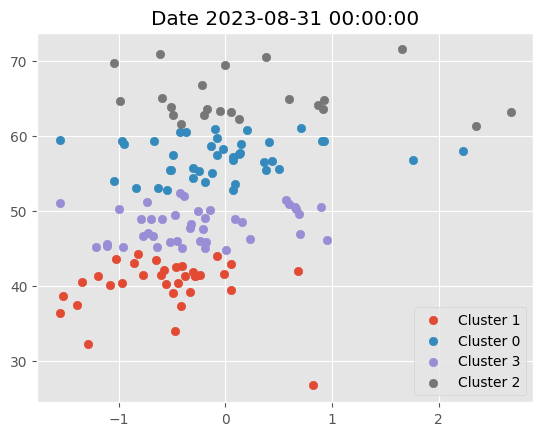

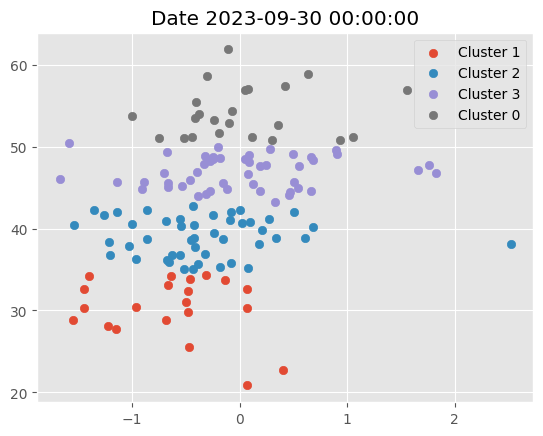

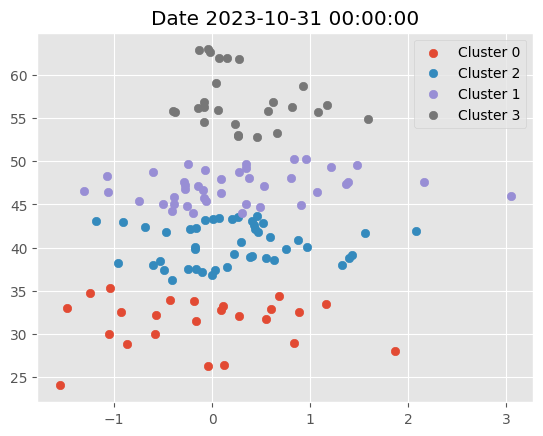

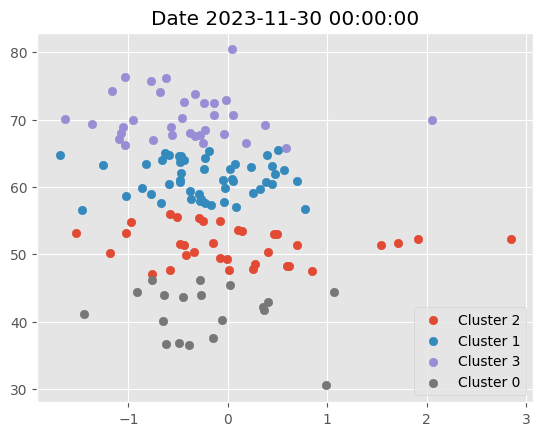

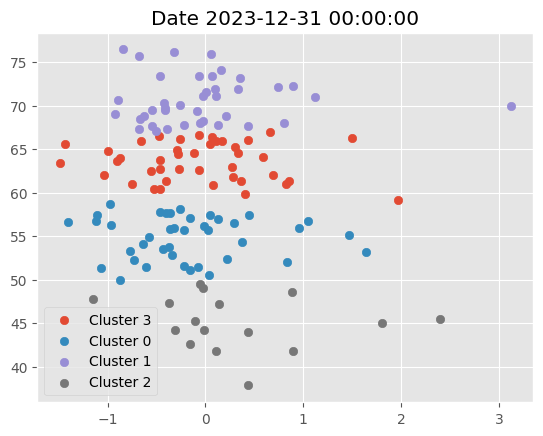

In [ ]:
# Final plotting
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g, cluster_column='cluster')

In [ ]:
###Apply pre-defined centroids.

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2019-11-01': ['AAPL',
  'ABBV',
  'ALGN',
  'AMD',
  'AMGN',
  'BIIB',
  'BMY',
  'CHTR',
  'CI',
  'INTC',
  'JPM',
  'LRCX',
  'MS',
  'TSLA',
  'VRTX'],
 '2019-12-01': ['AAPL',
  'ABBV',
  'ACN',
  'ADBE',
  'ADSK',
  'ALGN',
  'AMGN',
  'BLK',
  'CI',
  'CVS',
  'DIS',
  'ISRG',
  'JPM',
  'MAR',
  'MO',
  'MSFT',
  'REGN',
  'SCHW',
  'TGT',
  'UNH',
  'USB',
  'VRTX',
  'WFC'],
 '2020-01-01': ['ADSK',
  'ALGN',
  'AMAT',
  'AMT',
  'AMZN',
  'BDX',
  'BKNG',
  'BLK',
  'BRK-B',
  'BSX',
  'CHTR',
  'CI',
  'CMG',
  'COP',
  'EA',
  'EL',
  'ELV',
  'EOG',
  'FCX',
  'GS',
  'HAL',
  'ILMN',
  'INTC',
  'KO',
  'LIN',
  'LOW',
  'LRCX',
  'MA',
  'MDLZ',
  'MO',
  'MRK',
  'MS',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'OXY',
  'REGN',
  'SLB',
  'TGT',
  'TMO',
  'TXN',
  'V',
  'WYNN'],
 '2020-02-01': ['AAL',
  'ALGN',
  'AMAT',
  'AVGO',
  'BA',
  'BAC',
  'BSX',
  'C',
  'CI',
  'CMCSA',
  'COP',
  'CSCO',
  'DAL',
  'DIS',
  'EBAY',
  'EL',
  'EOG',
  'F',
  'FCX',
  'FDX',
 

**Define portfolio optimization function**

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

In [ ]:
##Download Fresh Daily Prices Data only for short listed stocks.

stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df


[*********************100%%**********************]  146 of 146 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2018-10-31  34.426765   52.333450   61.636589   63.393215  146.955170   
2018-11-01  35.692738   53.136887   63.505089   64.505852  147.850204   
2018-11-02  35.653488   49.612282   62.990456   64.542648  146.740723   
2018-11-05  35.151604   48.203876   65.381485   64.726555  147.868881   
2018-11-06  34.610352   48.725159   66.236588   65.250702  148.633362   
...               ...         ...         ...         ...         ...   
2023-12-18  14.240000  195.889999  153.419998  108.059998  341.850006   
2023-12-19  14.300000  196.940002  153.600006  108.419998  341.510010   
2023-12-20  13.980000  194.830002  151.690002  107.400002  339.500000   
2023-12-21  14.350000  194.679993  152.589996  108.480003  348.750000   
2023-12-22  14.310000  193.600006  154.940002  109.029999  354.450012   

                                                                        ...  \
                  ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-10-31  245.759995   75.720490  129.044449  129.250000  221.199997  ...   
2018-11-01  245.279999   79.601036  126.205269  135.229996  230.949997  ...   
2018-11-02  239.639999   78.859299  126.035103  134.130005  229.750000  ...   
2018-11-05  239.889999   78.135658  126.653084  133.500000  228.119995  ...   
2018-11-06  240.559998   79.564850  128.901123  133.699997  229.369995  ...   
...                ...         ...         ...         ...         ...  ...   
2023-12-18  599.130005  196.589996  234.850006  239.139999  261.690002  ...   
2023-12-19  604.640015  197.830002  233.699997  238.160004  268.309998  ...   
2023-12-20  596.059998  192.190002  232.229996  236.710007  262.079987  ...   
2023-12-21  600.140015  196.279999  228.990005  241.889999  274.100006  ...   
2023-12-22  598.750000  197.100006  230.970001  242.759995  271.869995  ...   

              Volume                                                  \
                 USB         V     VRTX        VZ       WBA      WDC   
Date                                                                   
2018-10-31  13027000  13205300  1607500  24214400  12973900  7697900   
2018-11-01   9812100  16024000  1369000  22533200   6368700  9682100   
2018-11-02   8273600  17063100  1338100  14734400   7197900  7753100   
2018-11-05   5448300   6280000   801400  12733800   6061200  5951300   
2018-11-06   4635600   4732700   920200  12371200   6265500  3667700   
...              ...       ...      ...       ...       ...      ...   
2023-12-18   9678700   6041100  1867300  22057200  11156200  3150400   
2023-12-19   8609500   8731200  1595900  17642500  12503500  3798800   
2023-12-20  15460200   7240900   909500  18134600  10335700  5201800   
2023-12-21   8134200   6246700   819100  15421000  10668500  7347000   
2023-12-22   6898900   5111500   804200  13157900   9776300  2936500   

                                                   
                 WFC       WMT     WYNN       XOM  
Date                                               
2018-10-31  23667400  12354900  3323200  16629100  
2018-11-01  17654800   7735100  6067500  14159300  
2018-11-02  18285600   7303200  3883300  19350400  
2018-11-05  18990000   7616800  2213300  15815000  
2018-11-06  20696800   6368700  1523300   9063200  
...              ...       ...      ...       ...  
2023-12-18  20531700   8772000  1487600  21610400  
2023-12-19  20556400   8139000  2264100  18904700  
2023-12-20  20481500   7322600  2039600  20988900  
2023-12-21  11127700   6695900  1891800  19250900  
2023-12-22  10448000   6467400  1170500  12921800  

[1295 rows x 876 columns]



*   Calculate daily returns for each stock which could land up in our portfolio.
*   Then loop over each month start, select the stocks for the month and calculate their weights for the next month.


*   If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.
*   Calculated each day portfolio return.

















In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-01-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2019-11-01,0.016625
2019-11-04,0.005312
2019-11-05,-0.002372
2019-11-06,0.000197
2019-11-07,0.005238
...,...
2023-12-18,0.000323
2023-12-19,0.007542
2023-12-20,-0.016576


# 8. Visualize Portfolio returns and compare to SP500 returns.

In [148]:
# Assuming the data and processing code is already executed

# 8. Visualize Portfolio returns and compare to SP500 returns.
spy = yf.download(tickers='SPY',
                  start='2019-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

# Merging with the existing portfolio_df
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

# Save the merged DataFrame to a CSV file
portfolio_df.to_csv('portfolio_comparison.csv')

# # Download the CSV file from Colab
# from google.colab import files
# files.download('portfolio_comparison.csv')




[*********************100%%**********************]  1 of 1 completed


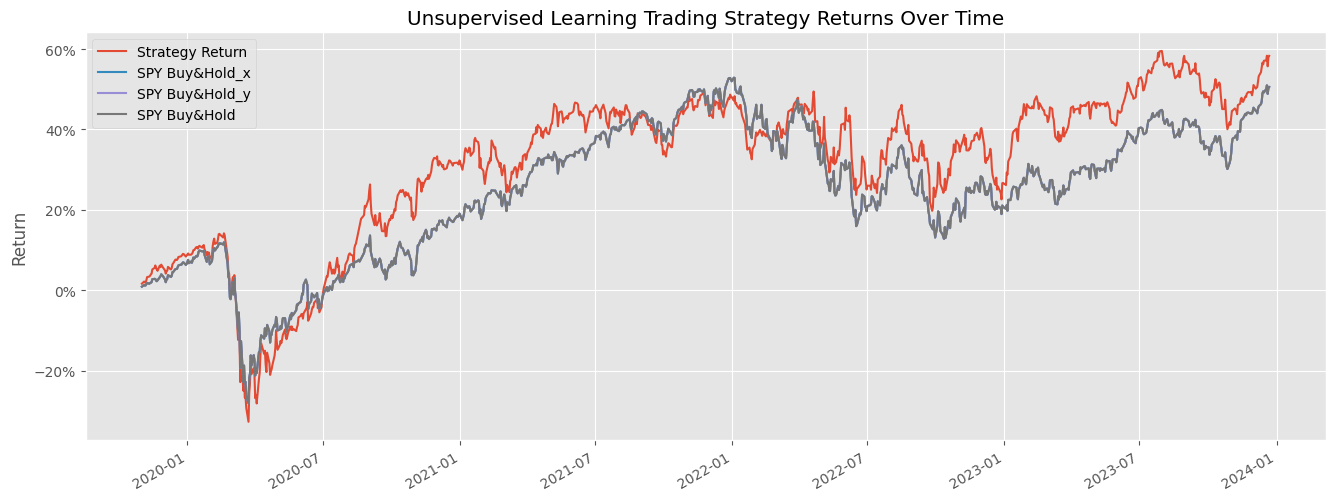

In [149]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2025-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()